In [1]:
%pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Weights and Bias to version the dataset and experiment tracking
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import warnings
warnings.filterwarnings("ignore")

In [5]:
import wandb

In [6]:
wandb.login()

wandb: Currently logged in as: alokpadhi. Use `wandb login --relogin` to force relogin


True

In [7]:
import ipywidgets as widgets

In [8]:
import json
import random

In [9]:
# Label encoder to encode class labels
class LabelEncoder(object):
    """Encode labels into unqiue ids/integers"""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        
    def __len__(self):
        return len(self.class_to_index)
    
    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"
    
    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self
    
    def encode(self, y):
        encoded = np.zeros(len(y), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded
    
    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
            
        return classes
    
    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)
    
    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [28]:
label_encoder = LabelEncoder.load("../../data_artifacts/new_label_encoder.json")

In [29]:
train_df = pd.read_parquet("../../dataset/v2.0/train.parquet")
val_df = pd.read_parquet("../../dataset/v2.0//val.parquet")
test_df = pd.read_parquet("../../dataset/v2.0/test.parquet")

In [30]:
# validate shapes
train_df.shape, val_df.shape, test_df.shape

((2483, 2), (532, 2), (533, 2))

In [31]:
# Feature and target
X_train = train_df.transcription.to_numpy()
y_train = train_df.specialty

X_val =  val_df.transcription.to_numpy()
y_val = val_df.specialty

X_test = test_df.transcription.to_numpy()
y_test = test_df.specialty

In [32]:
# Encode all our labels
y_train = label_encoder.encode(y_train)

y_val = label_encoder.encode(y_val)

y_test = label_encoder.encode(y_test)

In [33]:
def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [35]:
set_seeds()

In [36]:
# saving raw X_test to compare later
X_test_raw = X_test

In [37]:
vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,7)) # character n-gram

In [38]:
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [39]:
print(X_train.shape)

(2483, 1159914)


In [40]:
# class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print(f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [260  67 157 181  63  57 156  66 109  58 248 191 761 109],
class weights: {0: 0.0038461538461538464, 1: 0.014925373134328358, 2: 0.006369426751592357, 3: 0.0055248618784530384, 4: 0.015873015873015872, 5: 0.017543859649122806, 6: 0.00641025641025641, 7: 0.015151515151515152, 8: 0.009174311926605505, 9: 0.017241379310344827, 10: 0.004032258064516129, 11: 0.005235602094240838, 12: 0.001314060446780552, 13: 0.009174311926605505}


In [41]:
# Handling imbalanced data

In [42]:
!pip install imbalanced-learn==0.8.1

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [43]:
from imblearn.over_sampling import RandomOverSampler

In [44]:
# Oversample (Only on the training data)
oversample = RandomOverSampler(sampling_strategy="all")
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [45]:
# class weights after oversample
counts = np.bincount(y_over)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print(f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [761 761 761 761 761 761 761 761 761 761 761 761 761 761],
class weights: {0: 0.001314060446780552, 1: 0.001314060446780552, 2: 0.001314060446780552, 3: 0.001314060446780552, 4: 0.001314060446780552, 5: 0.001314060446780552, 6: 0.001314060446780552, 7: 0.001314060446780552, 8: 0.001314060446780552, 9: 0.001314060446780552, 10: 0.001314060446780552, 11: 0.001314060446780552, 12: 0.001314060446780552, 13: 0.001314060446780552}


## Linear Classifier
### With Stochastic gradient descent

In [46]:
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, precision_recall_fscore_support

In [47]:
# initialize model
model = SGDClassifier(
    loss="log", penalty="l2", alpha=1e-4, max_iter=1,
    learning_rate="constant", eta0=1e-1, power_t=0.1,
    warm_start=True
)

In [31]:
# num_epochs = 100
# train_losses = []
# val_losses = []
# for epoch in range(num_epochs):
#     model.fit(X_over, y_over)
    
#     y_train_pred = model.predict_proba(X_train)
#     train_loss = log_loss(y_train, y_train_pred)
    
#     y_val_pred = model.predict_proba(X_val)
#     val_loss = log_loss(y_val, y_val_pred)
    
#     if not epoch%10:
#         train_losses.append(train_loss)
#         val_losses.append(val_loss)
#         print(
#             f"Epoch: {epoch: 02d} | "
#             f"train_loss: {train_loss: .5f}, "
#             f"val_loss: {val_loss: .5f}"
       
#         )

In [48]:
# don't train on ovesamples one as earlier, use the raw X_train for train
model.fit(X_train, y_train)

SGDClassifier(eta0=0.1, learning_rate='constant', loss='log', max_iter=1,
              power_t=0.1, warm_start=True)

In [49]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print(json.dumps(performance, indent=2))

{
  "precision": 0.2941664121471268,
  "recall": 0.3302063789868668,
  "f1": 0.18761381511994735
}


In [50]:
ml_model_run = wandb.init(project="Medical-Transcription", name="SGDClassifier_nooversample")
# wandb.run.name = "Rule Based Model"
ml_model_run.log({"precision": performance["precision"], "recall": performance["recall"], "f1-score": performance["f1"]})

In [51]:
wandb.sklearn.plot_learning_curve(model, X_train, y_train)

In [52]:
wandb.sklearn.plot_precision_recall(y_test, y_pred_proba, label_encoder.classes)

wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.


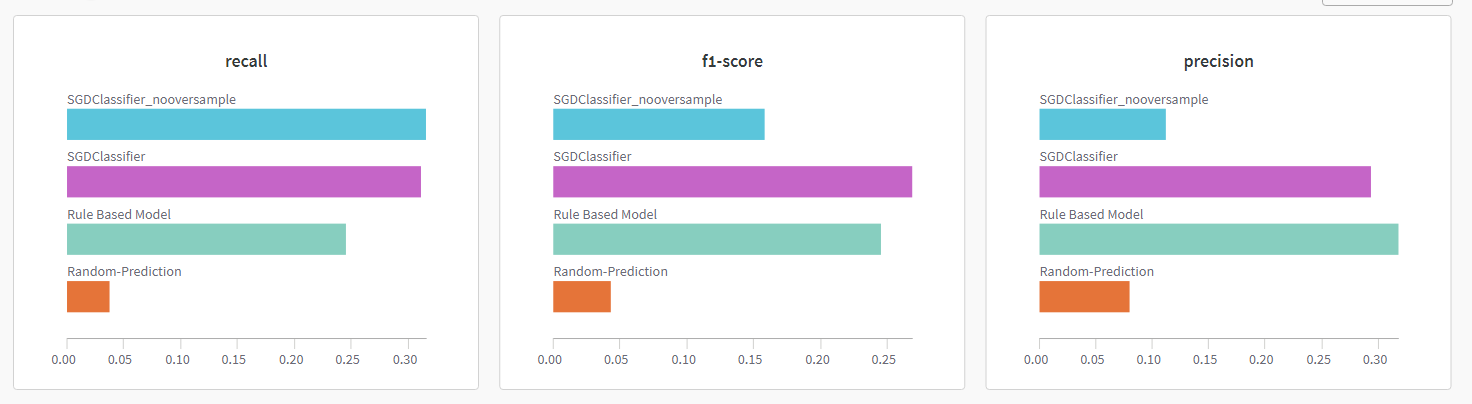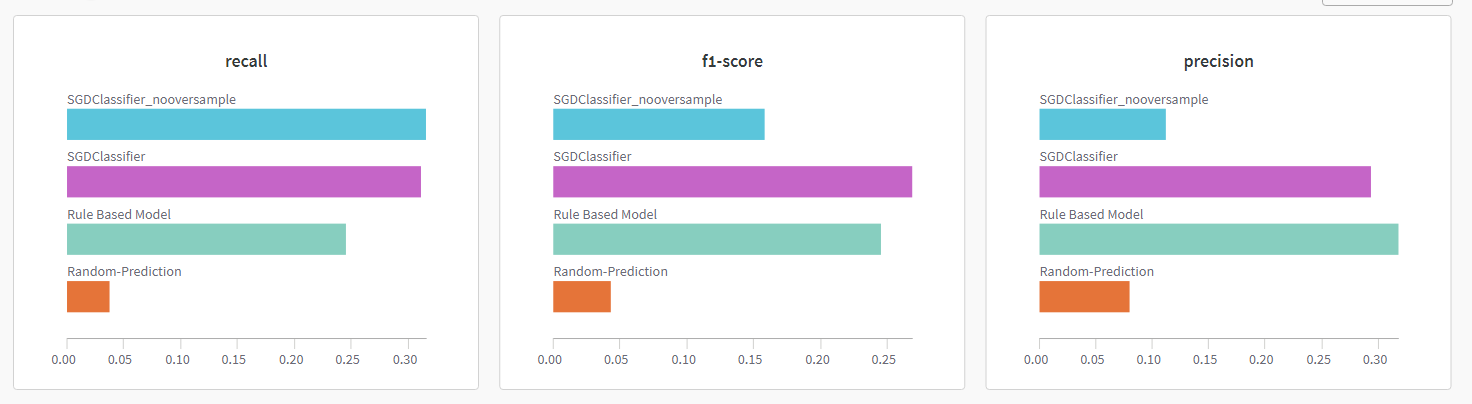